### Experiments with Simulated Data
Suppose we have $n=100$ training data points and another $50$ testing data points

Discrete Variables $X={X_1,X_2,X_3,X_4}$; $X_i \in \{0,1\}$; $X\in \mathcal{R}^{n\times 4}$

Continous Variable $\mathbf{z}$; $\mathbf{z} \in \mathcal{R}^{n \times 1}$

Continous Target Variable $\mathbf{y}$; $\mathbf{y} \in \mathcal{R}^{n \times 1}$

True Moderator Variable $X_1,X_2$

Data generated :
    $$y = z\beta_i+b_i+\epsilon$$

In [1]:
import numpy as np
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt
import itertools

#### Generating simulation data

In [35]:
# Xi ~ Ber(n,pi), z ~N(0,1)
probs = [0.4,0.6,0.4,0.6]
n = 150
X = np.zeros((n,4))
for i,p in enumerate(probs):
    X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
z = np.random.randn(n).reshape(n,1)
y = np.zeros(n)
features = np.hstack([X,z])
beta = np.random.randn(4,2)*2
print beta

[[-1.80749167  1.74274824]
 [ 1.83346927  2.50955861]
 [-3.65056916 -1.61338262]
 [ 0.29304958 -1.32141819]]


In [36]:
# y = z*beta_0+beta_1
for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = beta[0][0]*z[i]+beta[0][1]
        else: y[i] = beta[1][0]*z[i]+beta[1][1]
    else:
        if X[i][1]==0: y[i] = beta[2][0]*z[i]+beta[2][1]
        else: y[i] = beta[3][0]*z[i]+beta[3][1]
# add noise
y = y+np.random.randn(n)*0.5

In [37]:
# with open('data.pkl','w') as f:
#     pickle.dump((features,y),f)
# with open('coeff.pkl','w') as f:
#     pickle.dump(beta,f)

### Fit with MMR 
#### True model(including $X_1,X_2$ as moderator):
$$y = w_0 X_1+w_1 X_2+w_2Z+w_3ZX_1+w_4ZX_2+w_5ZX_1X_2+b+\epsilon$$

In [31]:
from sklearn.linear_model import LinearRegression as lr
import matplotlib.pyplot as plt

In [50]:
with open('data.pkl','r') as f:
    D,y = pickle.load(f)
with open('coeff.pkl','r') as f:
    true_coeff = pickle.load(f)
print true_coeff

[[-1.80749167  1.74274824]
 [ 1.83346927  2.50955861]
 [-3.65056916 -1.61338262]
 [ 0.29304958 -1.32141819]]


In [67]:
#### Reformat data
X = np.vstack([D[:,0],D[:,1],D[:,4],D[:,4]*D[:,0],D[:,4]*D[:,1],D[:,4]*D[:,0]*D[:,1]]).T
print X.shape

(150, 6)


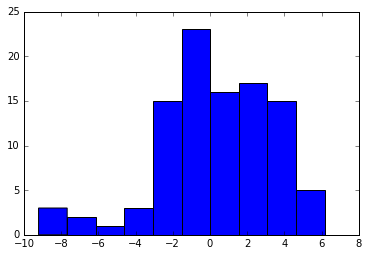

In [71]:
train_X = X[:100]
test_X = X[100:]
train_y = y[:100]
test_y = y[100:]
plt.hist(train_y)
plt.show()

In [74]:
model = lr()
model.fit(train_X,train_y)
print 'Baseline(sample mean):  {}'.format(np.mean((test_y-np.ones(50)*np.mean(train_y))**2))
print 'Training error:  {}'.format(np.mean((model.predict(train_X)-train_y)**2))
print 'Testing error:  {}'.format(np.mean((model.predict(test_X)-test_y)**2))

Baseline(sample mean):  6.27526373319
Training error:  0.206913093859
Testing error:  0.239249720806


### Fit with Multiple Linear Regression (including $Xs = {X_1,X_2,X_3,X_4}$ as moderator)
We see MLR is overfitting since we include too many features

In [75]:
from itertools import product

In [127]:
inds = list(product([0,1],repeat=4))

In [112]:
# introducint product terms
X = np.copy(D[:,:4])
for i in inds:
    Xprod = np.prod(D[:,np.nonzero(np.array(i))[0]],axis=1)
    X = np.hstack([X,(D[:,-1]*Xprod).reshape(-1,1)])

(150, 20)


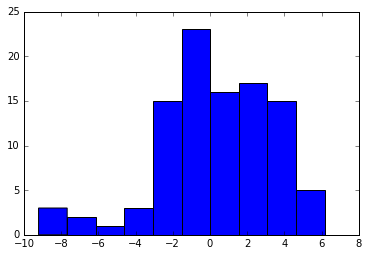

In [113]:
train_X = X[:100]
test_X = X[100:]
train_y = y[:100]
test_y = y[100:]
plt.hist(train_y)
plt.show()

If we include all $X_i$ as indicators, we see multiple linear regression(MLR) is **overfitting** 

since testing error is almost **twice** as large as training error 

In [114]:
model = lr()
model.fit(train_X,train_y)
print 'Baseline(sample mean):  {}'.format(np.mean((test_y-np.mean(train_y))**2))
print 'Training error:  {}'.format(np.mean((model.predict(train_X)-train_y)**2))
print 'Testing error:  {}'.format(np.mean((model.predict(test_X)-test_y)**2))

Baseline(sample mean):  6.27526373319
Training error:  0.170143148904
Testing error:  0.33116661003


### Fit with Lasso (including $Xs = {X_1,X_2,X_3,X_4}$ as moderator)

In [115]:
from sklearn import linear_model

In [143]:
alphas = np.linspace(0.01,0.5,10)
train_err = []
test_err = []
coeffs = []
for a in alphas:
    model = linear_model.Lasso(alpha=a)
    model.fit(train_X,train_y)
    train_err.append(np.mean((model.predict(train_X)-train_y)**2))
    test_err.append(np.mean((model.predict(test_X)-test_y)**2))    
    coeffs.append(model.coef_)

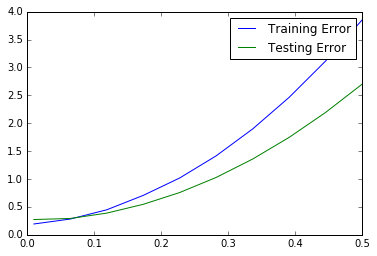

In [144]:
plt.plot(alphas,train_err,label = 'Training Error')
plt.plot(alphas,test_err,label='Testing Error')
plt.legend()
plt.show()

In [151]:
terms = np.array(['X1','X2','X3','X4','Z','ZX4','ZX3','ZX3X4',\
        'ZX2','ZX2X4','ZX2X3','ZX2X3X4',\
        'ZX1','ZX1X4','ZX1X3','ZX1X3X4',\
        'ZX1X2','ZX1X2X4','ZX1X2X3','ZX1X2X3X4'])
print 'nonzero product terms:'
for coeff in coeffs:
    print terms[np.nonzero(coeff)[0]]

nonzero product terms:
['X1' 'X2' 'X4' 'Z' 'ZX2' 'ZX2X3X4' 'ZX1' 'ZX1X4' 'ZX1X3' 'ZX1X2' 'ZX1X2X4'
 'ZX1X2X3X4']
['X1' 'X2' 'X4' 'Z' 'ZX2' 'ZX1']
['X1' 'X2' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']


### Experiments(Discrete Features)

X_1,X_2 are related dependent variables
#### Submodular

In [85]:
# Data generation
# Xi ~ Ber(n,pi)
probs = [0.4,0.6,0.4,0.6,0.4,0.6]
n = 1000
X = np.zeros((n,6))
for i,p in enumerate(probs):
    X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
beta = np.random.randn(4,2)*2
y = np.zeros(n)
for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = sum(beta[0][:2]*X[i][:2])+beta[0][1]
        else: y[i] = sum(beta[1][:2]*X[i][:2])+beta[1][1]
    else:
        if X[i][1]==0: y[i] = sum(beta[2][:2]*X[i][:2])+beta[2][1]
        else: y[i] = sum(beta[3][:2]**X[i][:2])+beta[3][1]
# add noise e~N(0,0.5^2)
y = y+np.random.randn(n)*0.5
train_X = X[:int(n*0.8)]
test_X = X[int(n*0.8):]
train_y = y[:int(n*0.8)]
test_y = y[int(n*0.8):]

In [86]:
# fit linear regression with given features 
def lr(features,train_X,train_y,test_X,test_y):
    features = np.array(list(features))
    n_feature =len(features)
    train_err = 0.0
    test_err = 0.0
    train_vector =np.sum(train_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    test_vector =np.sum(test_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    for v in range(2**n_feature):
        train_idx = np.where(train_vector==v)[0]
        test_idx = np.where(test_vector==v)[0]
        train_err += np.sum((np.mean(train_y[train_idx])-train_y[train_idx])**2)
        if len(test_idx)!=0:
            test_err += np.sum((np.mean(test_y[test_idx])-test_y[test_idx])**2)
    return train_err/len(train_y),test_err/len(test_y)

0.246651001141 0.175426473779
set([1, 2, 3, 4, 5]) 1.00033094342 0.797085298322
set([0, 2, 3, 4, 5]) 11.3133205688 9.7878990587
set([0, 1, 3, 4, 5]) 0.257756682902 0.196937820831
set([0, 1, 2, 4, 5]) 0.255535782528 0.207334636428
set([0, 1, 2, 3, 5]) 0.25905454692 0.209412060633
set([0, 1, 2, 3, 4]) 0.258840326359 0.216148386906
set([1, 2, 4, 5]) 1.01052577795 0.869342129316
set([0, 2, 4, 5]) 11.4355504038 10.5820086823
set([0, 1, 4, 5]) 0.261607115678 0.220587630556
set([0, 1, 2, 5]) 0.263884211009 0.219127128008
set([0, 1, 2, 4]) 0.263458738047 0.22290767043
set([1, 4, 5]) 1.01649842383 0.91875167696
set([0, 4, 5]) 11.5232059077 10.9155109276
set([0, 1, 5]) 0.266324590575 0.231722147562
set([0, 1, 4]) 0.265707852416 0.229249916019
set([1, 4]) 1.02236741593 0.933214890943
set([0, 4]) 11.564285702 11.0760137341
set([0, 1]) 0.267774246705 0.235162662402
set([1]) 1.02428294494 0.976760984819
set([0]) 11.6491285392 11.312378576
[ 0.00888478  0.00607133  0.00410074  0.00206639  0.7565087 ]

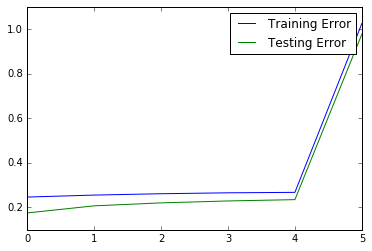

In [87]:
train_r = np.zeros(6)
test_r = np.zeros(6)
r = np.zeros(5)
feature_set = set(np.arange(6))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
train_r[0] = train_err
test_r[0] = test_err
removed = np.zeros(5)
for i in range(5):
    dr = 100
    f = 0
    for s in feature_set:
        feature_set.remove(s)
        train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
        print feature_set,train_err,test_err
        if train_err-train_r[i]<dr: 
            dr = train_err-train_r[i]
            train_r[i+1] = train_err
            test_r[i+1] = test_err
            f = s;
        feature_set.add(s)
    r[i] = train_r[i+1]-train_r[i]
    feature_set.remove(f)
    removed[i]=f
print r,removed
plt.plot(np.arange(6),train_r,label='Training Error')
plt.plot(np.arange(6),test_r,label = 'Testing Error')
plt.legend()
plt.show()

#### Lasso

In [88]:
def inter_terms(n,X):
    inds = list(itertools.product([0,1],repeat=n))
    ind_term = np.array(['X'+str(i+1) for i in range(6)])
    terms = []
    for i in inds:
        terms.append(''.join(ind_term[np.nonzero(np.array(i))[0]]))    
        Xprod = np.prod(X[:,np.nonzero(np.array(i))[0]],axis=1)
        X = np.hstack([X,Xprod.reshape(-1,1)])
    return X,terms[1:]
train_X,terms = inter_terms(6,train_X)
test_X,terms = inter_terms(6,test_X)

In [89]:
alphas = np.linspace(0.01,0.5,10)
train_err = []
test_err = []
coeffs = []
for a in alphas:
    model = linear_model.Lasso(alpha=a)
    model.fit(train_X,train_y)
    train_err.append(np.mean((model.predict(train_X)-train_y)**2))
    test_err.append(np.mean((model.predict(test_X)-test_y)**2))    
    coeffs.append(model.coef_)

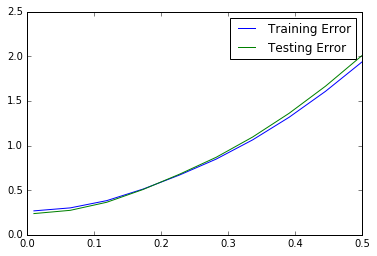

In [90]:
plt.plot(alphas,train_err,label = 'Training Error')
plt.plot(alphas,test_err,label='Testing Error')
plt.legend()
plt.show()

In [91]:
terms = np.array(terms)
for coeff in coeffs:
    print terms[np.nonzero(coeff)[0]]

['X6' 'X5' 'X4X5' 'X3' 'X3X5' 'X2X3X5X6' 'X1X4X5X6' 'X1X2X4X5X6']
['X6' 'X5' 'X2X4X5X6' 'X1X4X5X6' 'X1X2X4X5X6']
['X6' 'X5' 'X2X4X5X6' 'X1X4X5X6' 'X1X2X4X5X6']
['X6' 'X5' 'X2X4X5X6' 'X1X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']


#### Diminish Return Test for Submodularity 
$f(X \cup \{x\})-f(X)\geq f(Y \cup \{x\})-f(Y)\quad \text{if } X\subseteq Y\quad x\in \Omega \setminus Y$

In [94]:
for i in range(1,4):
    s_y = list(itertools.combinations(np.arange(6),i+2))
    for s in s_y:
        s_x = list(itertools.combinations(s,i+1))
        comp = set(np.arange(6)).difference(set(s))
        for sub_s_x in s_x:
            for c in comp:
                s = set(s)
                sub_s_x = set(sub_s_x )
                print 'X = {}; Y={}; x = {}'.format(sub_s_x,s,c)
                train_err1 = lr(s,train_X,train_y,test_X,test_y)[0]
                train_err2 = lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                s.add(c)
                sub_s_x.add(c)
                print train_err1 - lr(s,train_X,train_y,test_X,test_y)[0],\
                  train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                s.remove(c)
                sub_s_x.remove(c)

X = set([0, 1]); Y=set([0, 1, 2]); x = 3
0.00329233604327 0.00203828612873
X = set([0, 1]); Y=set([0, 1, 2]); x = 4
0.00283457163512 0.00206639428952
X = set([0, 1]); Y=set([0, 1, 2]); x = 5
0.00240909867367 0.00144965613023
X = set([0, 2]); Y=set([0, 1, 2]); x = 3
0.00329233604327 0.0199458499554
X = set([0, 2]); Y=set([0, 1, 2]); x = 4
0.00283457163512 0.136916576506
X = set([0, 2]); Y=set([0, 1, 2]); x = 5
0.00240909867367 0.0464998740206
X = set([1, 2]); Y=set([0, 1, 2]); x = 3
0.00329233604327 0.00123418888456
X = set([1, 2]); Y=set([0, 1, 2]); x = 4
0.00283457163512 0.00387162755182
X = set([1, 2]); Y=set([0, 1, 2]); x = 5
0.00240909867367 0.00481459850409
X = set([0, 1]); Y=set([0, 1, 3]); x = 2
0.0027349869376 0.00148093702306
X = set([0, 1]); Y=set([0, 1, 3]); x = 4
0.0026550530043 0.00206639428952
X = set([0, 1]); Y=set([0, 1, 3]); x = 5
0.00241212913469 0.00144965613023
X = set([0, 3]); Y=set([0, 1, 3]); x = 2
0.0027349869376 0.0226947349392
X = set([0, 3]); Y=set([0, 1, 3])

0.00394642671883 0.00241212913469
X = set([0, 2, 3]); Y=set([0, 1, 2, 3]); x = 4
0.0041606472796 0.202526288307
X = set([0, 2, 3]); Y=set([0, 1, 2, 3]); x = 5
0.00394642671883 0.0565257635988
X = set([1, 2, 3]); Y=set([0, 1, 2, 3]); x = 4
0.0041606472796 0.0108673985054
X = set([1, 2, 3]); Y=set([0, 1, 2, 3]); x = 5
0.00394642671883 0.00546306039251
X = set([0, 1, 2]); Y=set([0, 1, 2, 4]); x = 3
0.00461841168775 0.00329233604327
X = set([0, 1, 2]); Y=set([0, 1, 2, 4]); x = 5
0.00792295551877 0.00240909867367
X = set([0, 1, 4]); Y=set([0, 1, 2, 4]); x = 3
0.00461841168775 0.0026269448435
X = set([0, 1, 4]); Y=set([0, 1, 2, 4]); x = 5
0.00792295551877 0.00410073673783
X = set([0, 2, 4]); Y=set([0, 1, 2, 4]); x = 3
0.00461841168775 0.0855555617562
X = set([0, 2, 4]); Y=set([0, 1, 2, 4]); x = 5
0.00792295551877 0.0689633676901
X = set([1, 2, 4]); Y=set([0, 1, 2, 4]); x = 3
0.00461841168775 0.00822995983816
X = set([1, 2, 4]); Y=set([0, 1, 2, 4]); x = 5
0.00792295551877 0.00770748730324
X =

0.012403545779 0.0041606472796
X = set([0, 1, 2, 5]); Y=set([0, 1, 2, 3, 5]); x = 4
0.012403545779 0.00834842848022
X = set([0, 1, 3, 5]); Y=set([0, 1, 2, 3, 5]); x = 4
0.012403545779 0.0055671485396
X = set([0, 2, 3, 5]); Y=set([0, 1, 2, 3, 5]); x = 4
0.012403545779 0.25163816567
X = set([1, 2, 3, 5]); Y=set([0, 1, 2, 3, 5]); x = 4
0.012403545779 0.0150767001086
X = set([0, 1, 2, 4]); Y=set([0, 1, 2, 4, 5]); x = 3
0.00888478138719 0.00461841168775
X = set([0, 1, 2, 5]); Y=set([0, 1, 2, 4, 5]); x = 3
0.00888478138719 0.00482966408843
X = set([0, 1, 4, 5]); Y=set([0, 1, 2, 4, 5]); x = 3
0.00888478138719 0.00385043277567
X = set([0, 2, 4, 5]); Y=set([0, 1, 2, 4, 5]); x = 3
0.00888478138719 0.122229835029
X = set([1, 2, 4, 5]); Y=set([0, 1, 2, 4, 5]); x = 3
0.00888478138719 0.0101948345306
X = set([0, 1, 3, 4]); Y=set([0, 1, 3, 4, 5]); x = 2
0.0111056817611 0.00424058121291
X = set([0, 1, 3, 5]); Y=set([0, 1, 3, 4, 5]); x = 2
0.0111056817611 0.00426928452174
X = set([0, 1, 4, 5]); Y=set([